In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
%matplotlib inline

In [2]:
import tol_colors as tol

In [3]:
from collections import OrderedDict 

In [4]:
import copy

In [224]:
class PixelLists():
    def __init__(self):
        self.pixel_list_file = {
            "DeepTaylor": "richard_1px_deletion_game_CIFAR-10-original_mean_DeepTaylor_1563260594.pkl",
            "Gradient": "richard_1px_deletion_game_CIFAR-10-original_mean_Gradient_1563289738.pkl",
            "InputTimesGradient": "richard_1px_deletion_game_CIFAR-10-original_mean_InputTimesGradient_1563244779.pkl",
            "Shap": "richard_preservation_game_CIFAR-10-original_mean_Shap_1562776643.pkl",
            "EdgeDetection": "richard_preservation_game_CIFAR-10-original_mean_EdgeDetection_1566395882.pkl"
        }
        
        self.explanation_names = {
            "Shap": "SHAP",
            "DeepTaylor": "Deep Taylor",
            "Gradient": "Sensitivity",
            "InputTimesGradient": "Gradient x Input",
            "EdgeDetection": "Sobel Edge Detector"
        }
        
        self.pixel_list_dict = dict()
        for method in self.explanation_names.keys():
            self.pixel_list_dict[method] = []
            
    def load_pixel_list(self, method):
        fname = os.path.join("pixel_lists", self.pixel_list_file[method])
        with open(fname,"rb") as f:
            self.pixel_list_dict[method] = pickle.load(f,encoding='latin1')
            temp = []
            for l in self.pixel_list_dict[method]:
                d = {str(loc[0])+","+str(loc[1]): loc[2] for loc in l}
                d = OrderedDict(sorted(d.items(), key=lambda item: -item[1]))
                temp.append(d)
            self.pixel_list_dict[method] = temp
    
    def create_ordered_pixels_list(self, pix_weights, return_abs=False):
        pixel_weight_dict = OrderedDict()
        for i in range(pix_weights.shape[0]):
            for j in range(pix_weights.shape[1]):
                if(len(pix_weights[i][j].shape) > 0):
                    attribution_value = sum(pix_weights[i][j])
                else:
                    attribution_value = pix_weights[i][j]
                if return_abs:
                    attribution_value = np.abs(attribution_value)
                pixel_weight_dict[str(i)+","+str(j)] = attribution_value
        #return sorted(pixel_weight_list,key=lambda x: x[2],reverse=True)
        return OrderedDict(sorted(pixel_weight_dict.items(), key=lambda item: -item[1]))
            
    def generate_same_random_pixel_weights(self, images_shape, rseed):
        pixel_weight_size = list(images_shape[1:])
        pixel_weight_size[-1] = 1

        dataset_pixel_weight_lists = []
        random_generator = np.random.RandomState(rseed)
        pix_weights = random_generator.uniform(size=pixel_weight_size)

        for image_i in range(images_shape[0]):
            if(image_i % 100 == 0):
                print("Generating Random Pixel List for:" + str(image_i))
            pixel_weight_dict = self.create_ordered_pixels_list(pix_weights,return_abs=False)
            dataset_pixel_weight_lists.append(pixel_weight_dict)

        return dataset_pixel_weight_lists
            
    def generate_random_pixel_lists(self, rseed_list, images_shape=[1,32,32,3]):
        for rseed in rseed_list:
            rpl = self.generate_same_random_pixel_weights(images_shape, int(rseed))
            self.pixel_list_dict["random_" + str(rseed)] = rpl

class DeletionResults():
    
    def __init__(self, filter_list=[]):
        self.class_map = {
            0 : "airplane",
            1 : "automobile",
            2 : "bird",
            3 : "cat",
            4 : "deer",
            5 : "dog",
            6 : "frog",
            7 : "horse",
            8 : "ship",
            9 : "truck"
        }
        
        self.explanation_names = {
            "Shap": "SHAP",
            "DeepTaylor": "Deep Taylor",
            "Gradient": "Sensitivity",
            "InputTimesGradient": "Gradient x Input",
            "EdgeDetection": "Sobel Edge Detector"
        }
        
        self.filter_list = filter_list
        
        self.experiment_prefix = "richard"
        self.method_arr = ["Gradient", "Shap", "InputTimesGradient", "DeepTaylor", "EdgeDetection","random"]
        self.baseline_arr = {
            "": ["123","234","345","456","567","678","789","890","901","120"],
            "1px": ["123","234","345","456","567","678","789","890","901","120"]
        }
        for idx in range(1,91):
            self.baseline_arr["1px"].append(str(idx*1234))
        self.perturb_arr = ["mean", "random"]
        self.rate_arr = ["", "1px"]
        self.game_arr = ["deletion_game", "preservation_game"]
        self.dataset = "CIFAR-10-original"
        self.basedir = "paper_results"
        
    def get_experiment_name(self, rate, game, dataset, perturb, method, baseline=""):
        if baseline != "":
            baseline = "_" + baseline
        if rate != "":
            rate = "_" + rate
        return self.experiment_prefix + rate + "_" + game + "_" + dataset + "_" + perturb + "_" + method + baseline
    
    def filter_correct(self, df):
        index = np.where(df["ground_truth"] == df["original_prediction_i"])
        return index, df.loc[index]

    def filter_incorrect(self, df):
        index = np.where(df["ground_truth"] != df["original_prediction_i"])
        return index, df.loc[index]

    def filter_confident(self, df, confidence=0.99):
        colnames, _ = self.cols_to_plot(df)
        index = np.where(df[colnames[0]] >= confidence)
        return index, df.loc[index]

    def filter_not_confident(self, df, confidence=0.8):
        colnames, _ = self.cols_to_plot(df)
        index = np.where(df[colnames[0]] < confidence)
        return index, df.loc[index]
    
    def filter_no_change(self, df, ratio=0.95):
        colnames, _ = self.cols_to_plot(df)
        index = np.where(df[colnames[-1]] / df[colnames[0]] < ratio)
        return index, df.loc[index]

    def normalise_outputs(self, df):
        colnames, _, colvals = self.cols_to_plot(df, return_colvals=True)
        initial_scores = df[colnames[0]]
        for idx in range(colvals.shape[1]):
            colvals[:,idx] /= initial_scores
        df_normalised = df.copy()
        df_normalised[colnames] = colvals
        return df_normalised

    def aopc_outputs(self, df, rate, num_pixels=1024):
        colnames, _, colvals = self.cols_to_plot(df, return_colvals=True)
        initial_scores = df[colnames[0]]
        for idx in range(colvals.shape[1]):
            colvals[:,idx] = initial_scores - colvals[:,idx]
        if rate == "1px":
            L = np.arange(1,colvals.shape[1]+1,1)[None,:]
        else:
            L = np.arange(1,colvals.shape[1]+1,1)[None,:] #* (0.05*num_pixels)
        colvals = np.cumsum(colvals,1) / L
        df_normalised = df.copy()
        df_normalised[colnames] = colvals
        return df_normalised
    
    def cols_to_plot(self, df, return_colvals=False):
        """
        Returns the columns to plot from Dan's results CSVs, once loaded as dataframes
        """
        first = 0
        for idx, col in enumerate(df.columns):
            try:
                test = float(col)
            except ValueError:
                pass
            else:
                if test == 0:
                    first = idx
                    break
        if return_colvals:
            return (list(df.columns[first:]), \
                    np.array([float(val) for val in df.columns[first:]]), \
                    df[df.columns[first:]].to_numpy())
        return (list(df.columns[first:]), np.array([float(val) for val in df.columns[first:]]))
    
    def load_results(self, aopc=True):
        baseline_dict = dict()
        exmethod_dict = dict()
        baseline_dict_raw = dict()
        exmethod_dict_raw = dict()
        for perturb in self.perturb_arr:
            print("Loading perturbation type " + perturb)
            if perturb == "grid":
                my_rate_array = ["1px"]
            else:
                my_rate_array = self.rate_arr
            for rate in my_rate_array:
                print("Loading deletion rate type " + rate)
                for method in self.method_arr:
                    print("Loading method " + method)
                    if method == "random":
                        my_baseline_array = self.baseline_arr[rate]
                    else:
                        my_baseline_array = [""]
                    for baseline in my_baseline_array:
                        if baseline != "":
                            print("Baseline: " + baseline)
                        for game in self.game_arr:
                            if (baseline != "" and game == "deletion_game") or (baseline == ""):
                                print("Loading game " + game)
                                f = self.get_experiment_name(rate, game, self.dataset, perturb, method, baseline=baseline)
                                fname = os.path.join(self.basedir, f + "_results.csv")
                                df = pd.read_csv(fname)
                                index = np.arange(0,df.shape[0],1)
                                idx_list = []
                                if len(self.filter_list) != 0:
                                    for filt in self.filter_list:
                                        idx, df = getattr(self, filt)(df)
                                        idx_list.append(idx)
                                    for idx in idx_list:
                                        index = index[idx]
                                if aopc:
                                    dfaopc = self.aopc_outputs(copy.deepcopy(df), rate=rate, num_pixels=32*32)
                                else:
                                    dfaopc = None
                                if baseline == "":
                                    exmethod_dict_raw[f] = df
                                    exmethod_dict[f] = copy.deepcopy(dfaopc)
                                else:
                                    baseline_dict_raw[f] = df
                                    baseline_dict[f] = copy.deepcopy(dfaopc)
        self.exmethod_dict_raw = exmethod_dict_raw
        self.baseline_dict_raw = baseline_dict_raw
        self.exmethod_dict = exmethod_dict
        self.baseline_dict = baseline_dict
        self.sample_index = index
        self.data_shape = index.shape[0]
    
        
class Results():
        
    def __init__(self, filter_list=[], loaded_results=None, pixel_lists=None):
        
        self.colors = list(tol.tol_cset("high-contrast"))
        self.colors.append("#888888")
        self.linestyle = ["-", "-", "-", "-", "--"]
        
        if pixel_lists is not None:
            self.link_pixel_lists(pixel_lists)
        if loaded_results is not None:
            self.link_loaded_results(loaded_results)
        
        self.relevance_score_dict = dict()
        self.score_arr = dict()
        self.method_relevance = dict()
        
    def link_loaded_results(self,loaded_results):
        self.loaded_results = loaded_results
        self.class_map = self.loaded_results.class_map
        self.explanation_names = self.loaded_results.explanation_names
        self.filter_list = self.loaded_results.filter_list
        self.experiment_prefix = self.loaded_results.experiment_prefix
        self.method_arr = self.loaded_results.method_arr
        self.baseline_arr = self.loaded_results.baseline_arr
        self.perturb_arr = self.loaded_results.perturb_arr
        self.rate_arr = self.loaded_results.rate_arr
        self.game_arr = self.loaded_results.game_arr
        self.dataset = self.loaded_results.dataset
        self.basedir = self.loaded_results.basedir
        self.exmethod_dict_raw = self.loaded_results.exmethod_dict_raw
        self.baseline_dict_raw = self.loaded_results.baseline_dict_raw
        self.exmethod_dict = self.loaded_results.exmethod_dict
        self.baseline_dict = self.loaded_results.baseline_dict
        self.sample_index = self.loaded_results.sample_index
    
    def get_class(self, idx):
        """
        Translate from class ID to label
        """
        return self.class_map[idx]

    def get_method_name(self, method):
        return self.explanation_names[method]
    
    def cols_to_plot(self, df, return_colvals=False):
        """
        Returns the columns to plot from Dan's results CSVs, once loaded as dataframes
        """
        first = 0
        for idx, col in enumerate(df.columns):
            try:
                test = float(col)
            except ValueError:
                pass
            else:
                if test == 0:
                    first = idx
                    break
        if return_colvals:
            return (list(df.columns[first:]), \
                    np.array([float(val) for val in df.columns[first:]]), \
                    df[df.columns[first:]].to_numpy())
        return (list(df.columns[first:]), np.array([float(val) for val in df.columns[first:]]))

    def reconstruct_heatmap(self, method, idx=0):
        px_ids = np.array([[p[0], p[1]] for p in self.pixel_lists.pixel_list_dict[method][idx]]).flatten()
        wh = np.max(px_ids) + 1
        hm = np.zeros((wh,wh))
        for p in self.pixel_lists.pixel_list_dict[method][idx]:
            hm[p[0],p[1]] = p[2]
        return hm
    
    def get_experiment_name(self, rate, game, dataset, perturb, method, baseline=""):
        if baseline != "":
            baseline = "_" + baseline
        if rate != "":
            rate = "_" + rate
        return self.experiment_prefix + rate + "_" + game + "_" + dataset + "_" + perturb + "_" + method + baseline
        
    def filter_by_class(self, df, class_label=None):
        if class_label is not None:
            return df.loc[df["ground_truth"] == class_label]
        return df
    
    def link_pixel_lists(self, pixel_lists):
        self.pixel_lists = pixel_lists
    
    def get_all_scores_random_orderings(self, perturbation_type="mean"):
        # method_scores = dict()
        method_relevance = dict()
        scores_done = False
        for exmethod in self.method_arr[:-1]:
            print(exmethod)
            experiment = self.get_experiment_name("1px", "deletion_game", "CIFAR-10-original", \
                                                  perturbation_type, exmethod)
            method_pixel_weights = self.pixel_lists.pixel_list_dict[exmethod]
            _, _, temp = self.cols_to_plot(self.exmethod_dict_raw[experiment], return_colvals=True)
            if not scores_done:
                score_arr = np.zeros((len(self.baseline_arr["1px"]), temp.shape[0], temp.shape[1]-1))
            relev_arr = np.zeros((len(self.baseline_arr["1px"]), temp.shape[0], temp.shape[1]-1))
            for ridx, rseed in enumerate(self.baseline_arr["1px"]):
                print(rseed)
                randname = "random_" + str(rseed)
                experiment_rand = self.get_experiment_name("1px", "deletion_game", "CIFAR-10-original", \
                                                           perturbation_type, "random", baseline=rseed)
                rand_pixel_ordering = self.pixel_lists.pixel_list_dict[randname]
                if not scores_done:
                    _, _, colvals = self.cols_to_plot(self.baseline_dict_raw[experiment_rand], \
                                                      return_colvals=True)
                    score_diffs = colvals[:,0].reshape((colvals.shape[0],1)) - colvals[:,1:]
                relevance_sums = np.zeros(score_diffs.shape)
                for image_id in range(colvals.shape[0]):
                    #print(image_id, len(method_pixel_weights), len(rand_pixel_ordering))
                    rand_mpw = np.cumsum(np.array([method_pixel_weights[image_id][k] \
                                                   for k in rand_pixel_ordering[0].keys()]))
                    relevance_sums[image_id,:] = rand_mpw[:score_diffs.shape[1]]
                #print(score_arr.shape, score_diffs.shape)
                if not scores_done:
                    score_arr[ridx,:,:] = score_diffs
                relev_arr[ridx,:,:] = relevance_sums
            method_relevance[exmethod] = relev_arr
            scores_done = True
        #method_scores = score_arr
        self.score_arr[perturbation_type] = score_arr
        self.method_relevance[perturbation_type] = method_relevance
    
    def aix_fidelity(self, exmethod, perturbation_type="mean"):
        if perturbation_type not in self.score_arr.keys() or \
           perturbation_type not in self.method_relevance.keys():
            self.get_all_scores_random_orderings(perturbation_type=perturbation_type)
        score_rel_corr = np.zeros((10000,1))
        omitted = []
        for idx in range(self.data_shape):
            if idx % 100 == 0:
                print(idx)
            if(np.std(self.score_arr[perturbation_type][:,idx,0]) != 0 and \
                np.std(self.method_relevance[perturbation_type][perturbation_type][:,idx,0]) != 0):
                score_rel_corr[idx] = np.corrcoef(self.score_arr[perturbation_type][:,idx,0],\
                                                  self.method_relevance[perturbation_type][perturbation_type][:,idx,0])[1,0]
            else:
                omitted.append(idx)
        score_rel_corr_d = np.delete(score_rel_corr, omitted, 0)
        return score_rel_corr_d, omitted
    
    
    def plot_aix_fidelity(self, perturbation_type="mean",ax=None,size_inches=(10,5),bpc="#116611"):
        if ax is None:
            fig, ax = plt.subplots(len(self.methods_arr)-1,1)
        for idx, exmethod in enumerate(self.method_arr[:-1]):
            score_rel_corr_d, omitted = self.aix_fidelity(exmethod,perturbation_type=perturbation_type)
            method_lq = np.percentile(score_rel_corr_d,25)
            method_uq = np.percentile(score_rel_corr_d,75)
            method_median = np.median(score_rel_corr_d)
            method_mean = np.mean(score_rel_corr_d)
            plt.sca(ax[idx])
            sns.distplot(score_rel_corr_d, kde=True, rug=False, color=self.colors[idx])
            ax[idx].axvline(method_mean, color=bpc, linestyle='-')
            ax[idx].axvline(method_median, color=bpc, linestyle='--')
            ax[idx].axvline(method_lq, color=bpc, linestyle=':')
            ax[idx].axvline(method_uq, color=bpc, linestyle=':')
            print(exmethod, str(len(omitted)))
        plt.gcf().set_size_inches(size_inches[0], size_inches[1])
        return ax
 
    def score_relevance_correlation(self, ex_dict):
        experiment = self.get_experiment_name(ex_dict["rate"], ex_dict["game"], ex_dict["dataset"], \
                                              ex_dict["perturb"], ex_dict["method"])
        
        _, _, colvals_ex = self.cols_to_plot(self.exmethod_dict_raw[experiment], return_colvals=True)
        colvals_ex[colvals_ex==0] = 1e-8
        
        if ex_dict["method"] not in self.relevance_score_dict.keys():
            print("Converting relevance scores to correct format...")
            relmat = np.zeros((self.sample_index.shape[0], \
                               len(self.pixel_lists.pixel_list_dict[ex_dict["method"]][0])))
            for idx in self.sample_index:
                relmat[idx,:] = np.array([v[2] for v in self.pixel_lists.pixel_list_dict[ex_dict["method"]][idx]])
            relmat[relmat==0] = 1e-8
            self.relevance_score_dict[ex_dict["method"]] = relmat 
        
        r = np.zeros((colvals_ex.shape[0], 1))
        for idx in range(len(r)):
            r[idx] = np.corrcoef(colvals_ex[idx,1:], \
                                 self.relevance_score_dict[ex_dict["method"]][idx,0:colvals_ex.shape[1]-1])[0,1]
        return r
    
    def correlation_metric_ranking(self, ex_dict):
        metrank = dict()
        metrank_scores = dict()
        metrank["r"] = np.zeros((self.sample_index.shape[0], len(list(self.explanation_names.keys()))))
        metrank["m"] = np.zeros((self.sample_index.shape[0], len(list(self.explanation_names.keys()))))
        metrank_scores["r"] = np.zeros((self.sample_index.shape[0], len(list(self.explanation_names.keys()))))
        metrank_scores["m"] = np.zeros((self.sample_index.shape[0], len(list(self.explanation_names.keys()))))
        for idx, exmethod in enumerate(self.explanation_names.keys()):
            ex_dict["method"] = exmethod
            experiment = self.get_experiment_name(ex_dict["rate"], ex_dict["game"], ex_dict["dataset"], \
                                              ex_dict["perturb"], exmethod)
            _, _, colvals_ex = self.cols_to_plot(self.exmethod_dict[experiment], return_colvals=True)
            metrank["r"][:,idx] = np.squeeze(self.score_relevance_correlation(ex_dict))
            metrank["m"][:,idx] = np.squeeze(np.sum(colvals_ex,axis=1))
        for k,v in metrank.items():
            for row in range(v.shape[0]):
                metrank_scores[k][row,:] = sps.rankdata(v[row,:])
        return metrank, metrank_scores
    
    def get_baseline_adjusted_scores(self, exmethod_df, experiment, class_label=None):
        _, xvals, colvals_ex = self.cols_to_plot(exmethod_df, return_colvals=True)
        colvals_normed = []
        rate = ""
        if "1px" in experiment:
            rate = "1px"
        print("Number of random baseline measures: " + str(len(self.baseline_arr[rate])))
        for b in self.baseline_arr[rate]:
            temp = experiment.split("_")
            temp[-1] = "random"
            temp.append(b)
            experiment_bl = "_".join(temp) ###
            experiment_bl = experiment_bl.replace("preservation", "deletion")
            baseline = self.filter_by_class(self.baseline_dict[experiment_bl], class_label=class_label)
            _, _, colvals_bl = self.cols_to_plot(baseline, return_colvals=True)
            colvals_normed.append(colvals_ex - colvals_bl)
        return (np.mean(np.array(colvals_normed),axis=0), xvals)
    
    def plot_experiment_against_baseline(self, experiment, class_label=None, axis_label=None, \
                                         ax=None, legendloc='upper right', n_comparison_lines=50,ylim=[-1,1],\
                                         color="black", plot_id=(0,0), plot_id_legend=(-1,-1),linestyle="-",\
                                         size_inches=(10,15)):
        if ax is None:
            fig, ax = plt.subplots()
        exmethod = self.filter_by_class(self.exmethod_dict[experiment], class_label=class_label)
        colvals_mean, xvals = \
            self.get_baseline_adjusted_scores(exmethod, experiment, class_label=class_label)

        display_legend_all_axes = False
        if axis_label is None:
            if class_label is not None:
                axis_label = self.get_class(class_label)
                display_legend_all_axes = True
            else:
                axis_label = ""
        ax.plot(xvals, np.zeros(colvals_mean.shape[1]), color="black", \
                linewidth=3, alpha=0.85, linestyle=":", label='_nolegend_')
        if n_comparison_lines <= 100:
            alpha=0.15
        elif n_comparison_lines <= 500:
            alpha=0.1
        else:
            alpha=0.05
        for row in range(n_comparison_lines):
            ax.plot(xvals, colvals_mean[row,:], color="gray", \
                    linewidth=1, alpha=alpha, linestyle="-", label='_nolegend_')
        ax.plot(xvals, np.mean(colvals_mean,axis=0), color=color, \
                linewidth=3, alpha=1, linestyle=linestyle, label=axis_label)
        if display_legend_all_axes or plot_id_legend is None or plot_id_legend == plot_id:
            ax.legend(loc=legendloc)
        ax.set_ylim(ylim)
        plt.gcf().set_size_inches(size_inches[0], size_inches[1])
        return ax
    
    def plot_experiment_against_baseline_by_class(self, ex_dict, ax=None,ylim=[-1,1],size_inches=(10,15),\
                                                  n_comparison_lines=0,legendloc="upper right"):
        if ax is None:
            fig, ax = plt.subplots(5,2)
            if not isinstance(ax, np.ndarray):
                ax = np.array([[ax]])
        experiment = self.get_experiment_name(ex_dict["rate"], ex_dict["game"], ex_dict["dataset"], \
                                              ex_dict["perturb"], ex_dict["method"])
        count=0
        for ii in range(5):
            for jj in range(2):
                ax[ii,jj] = self.plot_experiment_against_baseline( \
                              experiment, class_label=count, ax=ax[ii,jj],ylim=ylim, \
                              n_comparison_lines=n_comparison_lines,legendloc=legendloc)
                count += 1
        plt.gcf().set_size_inches(size_inches[0], size_inches[1])
        return ax
    
    def plot_all_methods_experiment_against_baseline_by_class(self, ex_dict, ax=None,ylim=[-1,1],\
                                                              size_inches=(10,15),n_comparison_lines=0,\
                                                              include_edgedetect=False,legendloc="upper right"):
        if ax is None:
            fig, ax = plt.subplots(5,2)
            if not isinstance(ax, np.ndarray):
                ax = np.array([[ax]])
        count=0
        num_methods = len(self.method_arr)-1
        if not include_edgedetect:
            num_methods -= 1
        for ii in range(5):
            for jj in range(2):
                for kk in range(num_methods):
                    experiment = self.get_experiment_name(ex_dict["rate"], ex_dict["game"], ex_dict["dataset"], \
                                                          ex_dict["perturb"], self.method_arr[kk])
                    
                    ax[ii,jj] = self.plot_experiment_against_baseline( \
                                    experiment, class_label=count, \
                                    axis_label=self.get_method_name(self.method_arr[kk]),\
                                    ax=ax[ii,jj],ylim=ylim,color=self.colors[kk],\
                                    plot_id=(ii,jj), plot_id_legend=(0,1),linestyle=self.linestyle[kk],\
                                    n_comparison_lines=n_comparison_lines,legendloc=legendloc)
                count += 1
        plt.gcf().set_size_inches(size_inches[0], size_inches[1])
        return ax
    
    def plot_all_methods_experiment_against_baseline_by_deletion(self, ex_dict, ax=None,ylim=[-1,1],\
                                                                 perturb=None,size_inches=(10,15),\
                                                                 n_comparison_lines=0,include_edgedetect=True,\
                                                                legendloc="upper right"):
        if perturb is None:
            perturb = self.perturb_arr
        if ax is None:
            fig, ax = plt.subplots(1,len(perturb))
            if not isinstance(ax, np.ndarray):
                ax = np.array([[ax]])
        count=0
        num_methods = len(self.method_arr)-1
        if not include_edgedetect:
            num_methods -= 1
        for ii in range(1):
            for jj in range(len(perturb)):
                for kk in range(num_methods):
                    experiment = self.get_experiment_name(ex_dict["rate"], ex_dict["game"], ex_dict["dataset"], \
                                                     perturb[jj], self.method_arr[kk])
                    ax[jj] = self.plot_experiment_against_baseline( \
                                    experiment, class_label=count, \
                                    axis_label=self.get_method_name(self.method_arr[kk]),\
                                    ax=ax[jj],ylim=ylim,color=self.colors[kk],\
                                    plot_id=(ii,jj), plot_id_legend=(0,2),linestyle=self.linestyle[kk],\
                                    n_comparison_lines=n_comparison_lines,legendloc=legendloc)
                count += 1
        plt.gcf().set_size_inches(size_inches[0], size_inches[1])
        return ax
    
    def plot_experiment_against_baseline_by_method(self, ex_dict, ax=None, ylim=[-1,1],size_inches=(10,15),\
                                                   n_comparison_lines=0,legendloc="upper right"):
        if ax is None:
            fig, ax = plt.subplots(3,2)
            if not isinstance(ax, np.ndarray):
                ax = np.array([[ax]])
        count=0
        for ii in range(3):
            for jj in range(2):
                print(ii,jj)
                if ii == 2 and jj == 1:
                    break
                experiment = self.get_experiment_name(ex_dict["rate"], ex_dict["game"], ex_dict["dataset"], \
                                                 ex_dict["perturb"], self.method_arr[count])
                print(experiment)
                ax[ii,jj] = self.plot_experiment_against_baseline( \
                                experiment, ax=ax[ii,jj], \
                                axis_label=self.get_method_name(self.method_arr[count]),ylim=ylim,\
                                plot_id=(ii,jj), plot_id_legend=None,n_comparison_lines=n_comparison_lines,\
                                                                 legendloc=legendloc)
                count += 1
        plt.gcf().set_size_inches(size_inches[0], size_inches[1])
        return ax
    
    def plot_aopc_distribution(self, ex_dict, size_inches=(10,15),ind=-1,ylim=(0,2500),xlim=(-1,1)):
        fig, ax = plt.subplots(2,2)
        count=0
        for jj in range(2):
            for ii in range(2):
                experiment = self.get_experiment_name(ex_dict["rate"], ex_dict["game"], ex_dict["dataset"], \
                                                 ex_dict["perturb"], self.method_arr[count])
                print(experiment)
                #_, _, colvals_ex = self.cols_to_plot(self.exmethod_dict_raw[experiment], return_colvals=True)
                colvals_ex, _ = self.get_baseline_adjusted_scores(self.exmethod_dict[experiment], experiment)
                colvals_ex[colvals_ex==0] = 1e-8
                sns.distplot(colvals_ex[:,ind],ax=ax[ii,jj], kde=False, \
                             label=self.explanation_names[self.method_arr[count]], \
                                   color=self.colors[count])
                ax[ii,jj].legend(loc="upper left")
                ax[ii,jj].set_xlim(xlim)
                ax[ii,jj].set_ylim(ylim)
                count += 1
        plt.gcf().set_size_inches(size_inches[0], size_inches[1])
        return ax

In [209]:
results_aopc.sample_index.shape

(10000,)

In [33]:
pl = PixelLists()
pl.load_pixel_list("Gradient")
pl.load_pixel_list("InputTimesGradient")
pl.load_pixel_list("Shap")
pl.load_pixel_list("DeepTaylor")
pl.load_pixel_list("EdgeDetection")

In [35]:
lr = DeletionResults()
lr.load_results(aopc=True)

Loading perturbation type mean
Loading deletion rate type 
Loading method Gradient
Loading game deletion_game
Loading game preservation_game
Loading method Shap
Loading game deletion_game
Loading game preservation_game
Loading method InputTimesGradient
Loading game deletion_game
Loading game preservation_game
Loading method DeepTaylor
Loading game deletion_game
Loading game preservation_game
Loading method EdgeDetection
Loading game deletion_game
Loading game preservation_game
Loading method random
Baseline: 123
Loading game deletion_game
Baseline: 234
Loading game deletion_game
Baseline: 345
Loading game deletion_game
Baseline: 456
Loading game deletion_game
Baseline: 567
Loading game deletion_game
Baseline: 678
Loading game deletion_game
Baseline: 789
Loading game deletion_game
Baseline: 890
Loading game deletion_game
Baseline: 901
Loading game deletion_game
Baseline: 120
Loading game deletion_game
Loading deletion rate type 1px
Loading method Gradient
Loading game deletion_game
Load

Baseline: 22212
Loading game deletion_game
Baseline: 23446
Loading game deletion_game
Baseline: 24680
Loading game deletion_game
Baseline: 25914
Loading game deletion_game
Baseline: 27148
Loading game deletion_game
Baseline: 28382
Loading game deletion_game
Baseline: 29616
Loading game deletion_game
Baseline: 30850
Loading game deletion_game
Baseline: 32084
Loading game deletion_game
Baseline: 33318
Loading game deletion_game
Baseline: 34552
Loading game deletion_game
Baseline: 35786
Loading game deletion_game
Baseline: 37020
Loading game deletion_game
Baseline: 38254
Loading game deletion_game
Baseline: 39488
Loading game deletion_game
Baseline: 40722
Loading game deletion_game
Baseline: 41956
Loading game deletion_game
Baseline: 43190
Loading game deletion_game
Baseline: 44424
Loading game deletion_game
Baseline: 45658
Loading game deletion_game
Baseline: 46892
Loading game deletion_game
Baseline: 48126
Loading game deletion_game
Baseline: 49360
Loading game deletion_game
Baseline: 5

In [36]:
pl.generate_random_pixel_lists(lr.baseline_arr["1px"], images_shape=[1,32,32,3])

Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pixel List for:0
Generating Random Pi

In [65]:
results_aopc = Results(pixel_lists=pl, loaded_results=lr)
#results_corr = Results(pixel_lists=pl)

In [66]:
method_scores, method_relevance = results_aopc.get_all_scores_random_orderings()

Gradient
123
234
345
456
567
678
789
890
901
120
1234
2468
3702
4936
6170
7404
8638
9872
11106
12340
13574
14808
16042
17276
18510
19744
20978
22212
23446
24680
25914
27148
28382
29616
30850
32084
33318
34552
35786
37020
38254
39488
40722
41956
43190
44424
45658
46892
48126
49360
50594
51828
53062
54296
55530
56764
57998
59232
60466
61700
62934
64168
65402
66636
67870
69104
70338
71572
72806
74040
75274
76508
77742
78976
80210
81444
82678
83912
85146
86380
87614
88848
90082
91316
92550
93784
95018
96252
97486
98720
99954
101188
102422
103656
104890
106124
107358
108592
109826
111060
Shap
123
234
345
456
567
678
789
890
901
120
1234
2468
3702
4936
6170
7404
8638
9872
11106
12340
13574
14808
16042
17276
18510
19744
20978
22212
23446
24680
25914
27148
28382
29616
30850
32084
33318
34552
35786
37020
38254
39488
40722
41956
43190
44424
45658
46892
48126
49360
50594
51828
53062
54296
55530
56764
57998
59232
60466
61700
62934
64168
65402
66636
67870
69104
70338
71572
72806
74040
75274
76508
7

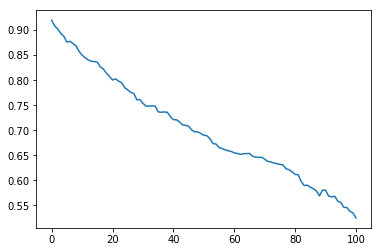

In [159]:
_,_,temp = results_aopc.cols_to_plot(results_aopc.baseline_dict_raw['richard_1px_deletion_game_CIFAR-10-original_mean_random_2468'],return_colvals=True)
plt.plot(np.mean(temp,axis=0))

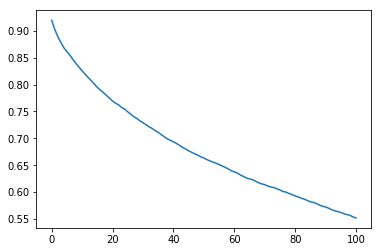

In [164]:
_,_,temp = results_aopc.cols_to_plot(results_aopc.exmethod_dict_raw['richard_1px_deletion_game_CIFAR-10-original_mean_Gradient'],return_colvals=True)
plt.plot(np.mean(temp,axis=0))

In [195]:
score_rel_corr = np.zeros((10000,100))
omitted = []
for idx in range(10000):
    if idx % 100 == 0:
        print(idx)
    for jdx in range(100):
        if(np.std(method_scores["EdgeDetection"][:,idx,jdx]) != 0 and \
           np.std(method_relevance["EdgeDetection"][:,idx,jdx]) != 0):
            score_rel_corr[idx,jdx] = np.corrcoef(method_scores["EdgeDetection"][:,idx,jdx],\
                                                  method_relevance["EdgeDetection"][:,idx,jdx])[1,0]
        else:
            omitted.append((idx,jdx))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [197]:
to_delete = list(set([o[0] for o in omitted]))
score_rel_corr_d = np.delete(score_rel_corr, to_delete, 0)

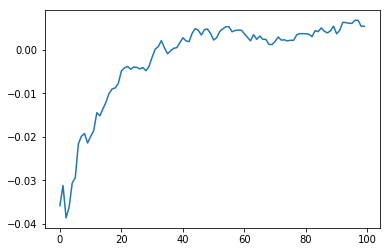

In [198]:
plt.plot(np.mean(score_rel_corr_d,axis=0))

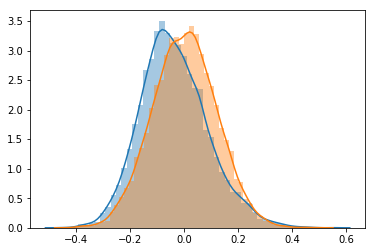

In [199]:
sns.distplot(score_rel_corr_d[:,0])
sns.distplot(score_rel_corr_d[:,50])

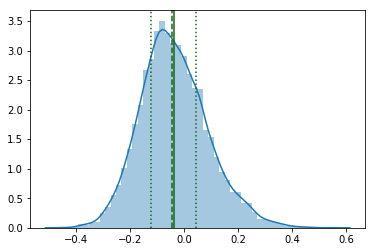

In [220]:
fig, ax = plt.subplots()
method_lq = np.percentile(score_rel_corr_d[:,0],25)
method_uq = np.percentile(score_rel_corr_d[:,0],75)
method_median = np.median(score_rel_corr_d[:,0])
method_mean = np.mean(score_rel_corr_d[:,0])
plt.sca(ax)
sns.distplot(score_rel_corr_d[:,0], kde=True, rug=False)
ax.axvline(method_mean, color="#116611", linestyle='-')
ax.axvline(method_median, color="#116611", linestyle='--')
ax.axvline(method_lq, color="#116611", linestyle=':')
ax.axvline(method_uq, color="#116611", linestyle=':')

In [223]:
np.sum(score_rel_corr_d[:,0]>method_uq)/score_rel_corr_d.shape[0]

0.25

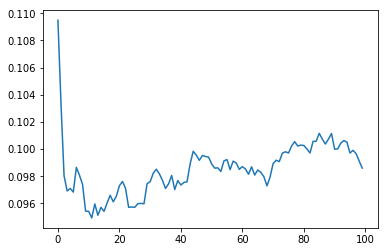

In [147]:
plt.plot(np.mean(score_rel_corr_d,axis=0))

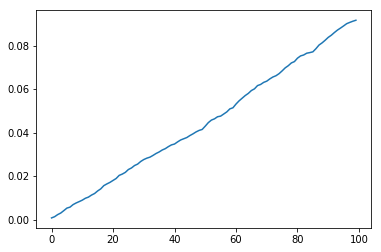

In [206]:
plt.plot(np.mean(method_relevance["Shap"][:,0,:],axis=0))

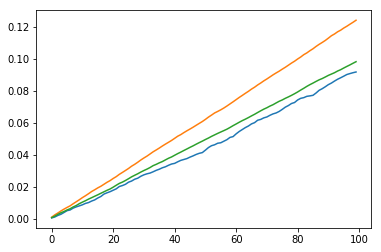

In [87]:
#plt.plot(np.mean(method_relevance["Gradient"][:,0,:],axis=0))
#plt.plot(np.mean(method_relevance["InputTimesGradient"][:,0,:],axis=0))
plt.plot(np.mean(method_relevance["Shap"][:,0,:],axis=0))
plt.plot(np.mean(method_relevance["DeepTaylor"][:,0,:],axis=0))
plt.plot(np.mean(method_relevance["EdgeDetection"][:,0,:],axis=0))

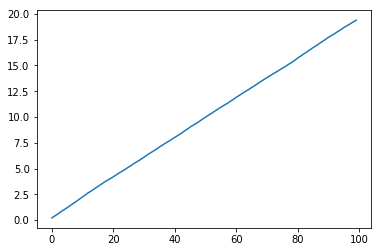

In [88]:
plt.plot(np.mean(method_relevance["Gradient"][:,0,:],axis=0))

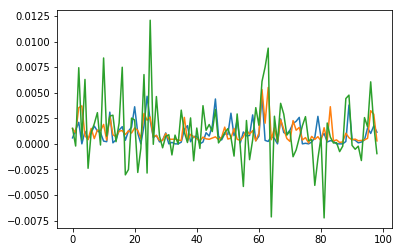

In [104]:
plt.plot(np.diff(method_relevance["EdgeDetection"][70,0,:]))
plt.plot(np.diff(method_relevance["DeepTaylor"][70,0,:]))
plt.plot(np.diff(method_relevance["Shap"][70,0,:]))

In [110]:
np.corrcoef(np.diff(method_relevance["Gradient"][70,0,:]),np.diff(method_relevance["Shap"][70,0,:]))

array([[1.        , 0.03627294],
       [0.03627294, 1.        ]])

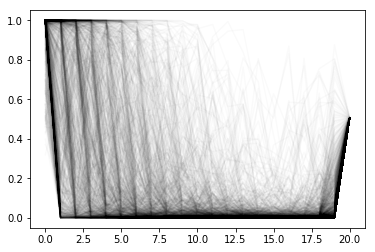

In [186]:
_,_,v = results_aopc.cols_to_plot(results_aopc.exmethod_dict_raw["richard_deletion_game_CIFAR-10-original_mean_Gradient"],return_colvals=True)
to_plot = results_aopc.exmethod_dict_raw["richard_deletion_game_CIFAR-10-original_random_Gradient"]["original_prediction_i"]==8
v = v[to_plot,:]
for idx in range(v.shape[0]):
    plt.plot(v[idx,:],alpha=0.02,color='black')

In [172]:
to_plot

,explanation_name,ground_truth,original_prediction_i,img_i,trial_i,0.0,0.05,0.1,0.15,0.2,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
1,Gradient,8,8,1,0,0.999959,0.993671,0.601039,0.015204,0.001593,...,0.010223,0.005213,0.004464,0.010213,0.001889,0.000279,0.000694,0.000233,0.002320,0.50685
2,Gradient,8,8,2,0,0.993251,0.030043,0.069260,0.011247,0.067575,...,0.023384,0.014369,0.007237,0.020248,0.012048,0.008048,0.001696,0.001457,0.002255,0.50685
15,Gradient,8,8,15,0,0.990398,0.998658,0.930466,0.074128,0.016083,...,0.007502,0.012141,0.010304,0.002449,0.001990,0.006753,0.000379,0.000030,0.009880,0.50685
18,Gradient,8,8,18,0,0.999998,0.146327,0.127575,0.031872,0.018986,...,0.006174,0.008356,0.001655,0.000682,0.001043,0.000414,0.000628,0.006874,0.035165,0.50685
32,Gradient,4,8,32,0,0.908821,0.589582,0.306527,0.471755,0.182869,...,0.095880,0.153393,0.082088,0.236421,0.309200,0.089497,0.110812,0.073690,0.160962,0.50685
51,Gradient,8,8,51,0,0.999931,0.466427,0.008800,0.019246,0.039765,...,0.000735,0.002654,0.011708,0.010055,0.005686,0.056916,0.005458,0.005805,0.048575,0.50685
54,Gradient,8,8,54,0,0.979135,0.833191,0.992830,0.987129,0.958989,...,0.019356,0.045856,0.023375,0.001124,0.000996,0.017705,0.026864,0.004565,0.019725,0.50685
55,Gradient,8,8,55,0,0.999990,0.025738,0.062032,0.031366,0.019071,...,0.066709,0.107604,0.293957,0.655427,0.193020,0.031493,0.016538,0.264961,0.129482,0.50685
72,Gradient,8,8,72,0,0.999999,0.999976,0.684133,0.044764,0.049200,...,0.004864,0.001331,0.014979,0.004561,0.022136,0.047200,0.531749,0.198172,0.194365,0.50685
73,Gradient,8,8,73,0,0.999990,0.999999,0.999553,0.922256,0.151445,...,0.023535,0.066426,0.089964,0.036031,0.162633,0.539903,0.608609,0.048797,0.072900,0.50685


In [170]:
results_aopc.exmethod_dict_raw["richard_deletion_game_CIFAR-10-original_mean_Gradient"][["original_prediction_i","1.0"]]

,original_prediction_i,1.0
0,3,0.007633
1,8,0.506850
2,8,0.506850
3,0,0.425317
4,6,0.030763
5,6,0.030763
6,1,0.000124
7,6,0.030763
8,3,0.007633
9,1,0.000124


Number of random baseline measures: 100
Number of random baseline measures: 100
Number of random baseline measures: 100
Number of random baseline measures: 100
Number of random baseline measures: 100
Number of random baseline measures: 100
Number of random baseline measures: 100
Number of random baseline measures: 100
Number of random baseline measures: 100
Number of random baseline measures: 100


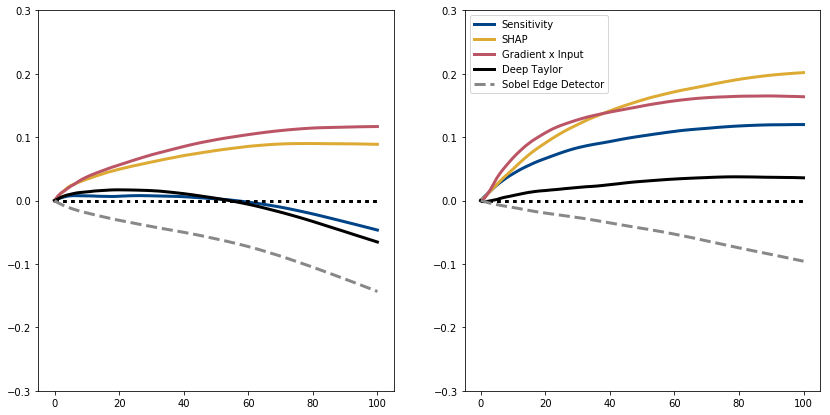

In [15]:
ex_dict = dict()
ex_dict["rate"] = "1px"
ex_dict["game"] = "deletion_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "mean"
ex_dict["method"] = "Gradient"
results_aopc.plot_all_methods_experiment_against_baseline_by_deletion(ex_dict,ylim=[-0.3,0.3],\
                                                                      size_inches=(14,7),\
                                                                      include_edgedetect=True)
plt.gca().legend()
#plt.savefig("presentation/AOPC_1px_deletion_game_all_methods.pdf", dpi=300)

In [ ]:
ex_dict = dict()
ex_dict["rate"] = "1px"
ex_dict["game"] = "preservation_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "mean"
ex_dict["method"] = "Gradient"
results_aopc.plot_all_methods_experiment_against_baseline_by_deletion(ex_dict,ylim=[-0.2,0.2],\
                                                                      size_inches=(14,7),\
                                                                      include_edgedetect=True)
plt.gca().legend()
plt.savefig("presentation/AOPC_1px_preservation_game_all_methods.pdf", dpi=300)

In [ ]:
ex_dict = dict()
ex_dict["rate"] = ""
ex_dict["game"] = "deletion_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "mean"
ex_dict["method"] = "Gradient"
results_aopc.plot_all_methods_experiment_against_baseline_by_deletion(ex_dict,ylim=[-0.5,0.5],\
                                                                      size_inches=(14,7),\
                                                                      include_edgedetect=True)
plt.gca().legend()
plt.savefig("presentation/AOPC_deletion_game_all_methods.pdf", dpi=300)

In [ ]:
ex_dict = dict()
ex_dict["rate"] = ""
ex_dict["game"] = "preservation_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "mean"
ex_dict["method"] = "Gradient"
results_aopc.plot_all_methods_experiment_against_baseline_by_deletion(ex_dict,ylim=[-0.7,0.1],\
                                                                      size_inches=(14,7),\
                                                                      include_edgedetect=True)
plt.gca().legend()
plt.savefig("presentation/AOPC_preservation_game_all_methods.pdf", dpi=300)

In [ ]:
ex_dict = dict()
ex_dict["rate"] = "1px"
ex_dict["game"] = "deletion_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "random"
ex_dict["method"] = "Gradient"
results_aopc.plot_experiment_against_baseline_by_method(ex_dict,ylim=[-0.8,0.8],size_inches=(15,12),n_comparison_lines=2500)
plt.savefig("presentation/AOPC_1px_deletion_game_all_methods_mean_show_individual.pdf", dpi=300)

In [ ]:
ex_dict = dict()
ex_dict["rate"] = "1px"
ex_dict["game"] = "deletion_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "random"
ex_dict["method"] = "DeepTaylor"
results_aopc.plot_experiment_against_baseline_by_class(ex_dict,ylim=[-0.8,0.8],size_inches=(15,15),n_comparison_lines=500)

In [ ]:
ex_dict = dict()
ex_dict["rate"] = "1px"
ex_dict["game"] = "deletion_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "mean"
ex_dict["method"] = "DeepTaylor"
results_aopc.plot_all_methods_experiment_against_baseline_by_class(ex_dict,ylim=[-0.3,0.3],size_inches=(14,20),\
                                                                   n_comparison_lines=0,legendloc="lower left",\
                                                                  include_edgedetect=True)
plt.savefig("presentation/AOPC_1px_deletion_game_all_methods_mean_by_class.pdf", dpi=300)

In [ ]:
ex_dict = dict()
ex_dict["rate"] = "1px"
ex_dict["game"] = "deletion_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "random"
ex_dict["method"] = "DeepTaylor"
results_aopc.plot_all_methods_experiment_against_baseline_by_class(ex_dict,ylim=[-0.3,0.3],size_inches=(14,20),\
                                                                   n_comparison_lines=0,legendloc="lower left",\
                                                                  include_edgedetect=True)
plt.savefig("presentation/AOPC_1px_deletion_game_all_methods_random_by_class.pdf", dpi=300)

In [ ]:
ex_dict = dict()
ex_dict["rate"] = "1px"
ex_dict["game"] = "preservation_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "mean"
ex_dict["method"] = "DeepTaylor"
results_aopc.plot_all_methods_experiment_against_baseline_by_class(ex_dict,ylim=[-0.4,0.3],size_inches=(14,20),\
                                                                   n_comparison_lines=0,legendloc="upper right",\
                                                                  include_edgedetect=True)
plt.savefig("presentation/AOPC_1px_preservation_game_all_methods_mean_by_class.pdf", dpi=300)

In [ ]:
ex_dict = dict()
ex_dict["rate"] = "1px"
ex_dict["game"] = "preservation_game"
ex_dict["dataset"] = "CIFAR-10-original"
ex_dict["perturb"] = "random"
ex_dict["method"] = "DeepTaylor"
results_aopc.plot_all_methods_experiment_against_baseline_by_class(ex_dict,ylim=[-0.6,0.3],size_inches=(14,20),\
                                                                   n_comparison_lines=0,legendloc="upper right",\
                                                                  include_edgedetect=True)
plt.savefig("presentation/AOPC_1px_preservation_game_all_methods_random_by_class.pdf", dpi=300)

In [ ]:
results_aopc.plot_aopc_distribution(ex_dict=ex_dict,ind=-1,xlim=(-0.9,0.9),ylim=(0,1250),size_inches=(12,10))
plt.savefig("presentation/AOPC_distributions_100px_deleted.pdf", dpi=300)

In [ ]:
results_aopc.plot_aopc_distribution(ex_dict=ex_dict,ind=-1,xlim=(-0.9,0.9),ylim=(0,1250),size_inches=(12,10))
plt.savefig("presentation/AOPC_distributions_100px_deleted.pdf", dpi=300)

In [ ]:
results_aopc.baseline_dict_raw['richard_1px_deletion_game_CIFAR-10-original_random_random_97486'].head()

In [ ]:
m, mr = results_aopc.correlation_metric_ranking(ex_dict)

In [ ]:
mr["r"]

In [ ]:
m["r"]

In [ ]:
np.sum(mr["r"]==1.,axis=0)

In [ ]:
np.sum(mr["r"]==2.,axis=0)

In [ ]:
np.sum(mr["r"]==3.,axis=0)

In [ ]:
np.sum(mr["r"]==4.,axis=0)

In [ ]:
np.sum(mr["r"]==5.,axis=0)

In [ ]:
m["m"]

In [ ]:
sr = []
for idx in range(10000):
    sr.append(sps.spearmanr(mr["r"][idx,:], mr["m"][idx,:])[0])
sns.distplot(np.array(sr))

In [ ]:
corr_scores = dict()
ex_dict["method"] = "Gradient"
corr_scores["Gradient"] = results_corr.score_relevance_correlation(ex_dict=ex_dict)
ex_dict["method"] = "InputTimesGradient"
corr_scores["InputTimesGradient"] = results_corr.score_relevance_correlation(ex_dict=ex_dict)
ex_dict["method"] = "Shap"
corr_scores["Shap"] = results_corr.score_relevance_correlation(ex_dict=ex_dict)
ex_dict["method"] = "DeepTaylor"
corr_scores["DeepTaylor"] = results_corr.score_relevance_correlation(ex_dict=ex_dict)
ex_dict["method"] = "EdgeDetection"
corr_scores["EdgeDetection"] = results_corr.score_relevance_correlation(ex_dict=ex_dict)

In [ ]:
for m in corr_scores.keys():
    sns.distplot(corr_scores[m][~np.isnan(corr_scores[m])], label=results_corr.get_method_name(m))
plt.gca().legend()

In [ ]:
class Model(): 
    def predict(self, x):
        return [0]
    
    def predict_proba(self, x):
        return [np.array([np.sum(x),0,0])]
    
def faithfulness_metric(model, x, coefs, base):
    """ This metric evaluates the correlation between the importance assigned by the interpretability algorithm
    to attributes and the effect of each of the attributes on the performance of the predictive model.
    The higher the importance, the higher should be the effect, and vice versa, The metric evaluates this by
    incrementally removing each of the attributes deemed important by the interpretability metric, and
    evaluating the effect on the performance, and then calculating the correlation between the weights (importance)
    of the attributes and corresponding model performance. [#]_
    References:
        .. [#] `David Alvarez Melis and Tommi Jaakkola. Towards robust interpretability with self-explaining
           neural networks. In S. Bengio, H. Wallach, H. Larochelle, K. Grauman, N. Cesa-Bianchi, and R. Garnett, editors,
           Advances in Neural Information Processing Systems 31, pages 7775-7784. 2018.
           <https://papers.nips.cc/paper/8003-towards-robust-interpretability-with-self-explaining-neural-networks.pdf>`_
    Args:
        model: Trained classifier, such as a ScikitClassifier that implements
            a predict() and a predict_proba() methods.
        x (numpy.ndarray): row of data.
        coefs (numpy.ndarray): coefficients (weights) corresponding to attribute importance.
        base ((numpy.ndarray): base (default) values of attributes
    Returns:
        float: correlation between attribute importance weights and corresponding effect on classifier.
    """

    #find predicted class
    pred_class = model.predict(x.reshape(1,-1))[0]

    #find indexs of coefficients in decreasing order of value
    ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
    pred_probs = np.zeros(x.shape[0])
    for ind in np.nditer(ar):
        x_copy = x.copy()
        x_copy[ind] = base[ind]
        print(x_copy)
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]
    print(coefs)
    print(pred_probs)
    return -np.corrcoef(coefs, pred_probs)[0,1]

m = Model()
x = np.array([4,3,6,5,2,8,7])
coefs = np.array([3,3,4,5,2,12,7])/3
base = np.zeros(7)

faithfulness_metric(m,x,coefs,base)

In [ ]:
np.random.rand(3)

In [ ]:
def GenerateSameRandomPixelWeights(images_shape, rseed):
    pixel_weight_size = list(images_shape[1:])
    pixel_weight_size[-1] = 1
    
    dataset_pixel_weight_lists = []
    random_generator = np.random.RandomState(rseed)
    pix_weights = random_generator.uniform(size=pixel_weight_size)

    for image_i in range(images_shape[0]):
        if(image_i % 100 == 0):
            print("Generating Random Pixel List for:" + str(image_i))
        pixel_weight_list = CreateOrderedPixelsList(pix_weights,return_abs=False)
        dataset_pixel_weight_lists.append(pixel_weight_list)
        
    return dataset_pixel_weight_lists

def CreateOrderedPixelsList(attribution_map, return_abs=False):
    pixel_weight_dict = OrderedDict()
    for i in range(attribution_map.shape[0]):
        for j in range(attribution_map.shape[1]):
            #TODO: decide best way to aggregate colour attribution
            if(len(attribution_map[i][j].shape) > 0):
                attribution_value = sum(attribution_map[i][j])
            else:
                attribution_value = attribution_map[i][j]
            if return_abs:
                attribution_value = np.abs(attribution_value)
            pixel_weight_dict[str(i)+","+str(j)] = attribution_value
    #TODO: confirm not taking the abs is correct
    return OrderedDict(sorted(pixel_weight_dict.items(), key=lambda item: -item[1]))

In [ ]:
temp = GenerateSameRandomPixelWeights([5,32,32,3],1234*33)
print([item for item in temp[0].items()])

In [ ]:
a = OrderedDict()
b = dict()
a[5] = 1
a[4] = 2
a[3] = 9
b[5] = 1
b[4] = 2
b[3] = 9
print(a)
print(b)

In [ ]:
a[5] = 7
a[1] = 0
b[5] = 7
b[1] = 0
print(a)
print(b)